In [1]:
import numpy as np
import pandas as pd
import ipdb
import pickle
import nnkcde
from cdetools.cdf_coverage import cdf_coverage
from cdetools.plot_utils import plot_with_uniform_band
from scipy.stats import norm, multivariate_normal
from scipy.integrate import simps
import statsmodels.api as sm
from sklearn.neural_network import MLPClassifier
import statsmodels.api as sm
from scipy.special import expit, logit

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from matplotlib.ticker import NullFormatter
import seaborn as sns

# omitted variable bias
# $Y \sim N(X+Z,\ \ 1)$
# $X,Z \sim N(0,1),\ \ \textrm{corr}(X,Z) = \rho$

In [107]:
def sample_X_Y_Z(rho=0.1, size=10000, var1=1, std2=1):
    joint_data = multivariate_normal.rvs(mean=[0,0], cov=var1*np.array([[1,rho],[rho,1]]), size=size)
    X_data = joint_data[:,0]
    Z_data = joint_data[:,1]
    Y_data = np.random.normal(loc=X_data+Z_data, scale=std2)
    return X_data, Y_data, Z_data

In [108]:
def get_true_conditional_dist(X, Z, std=1):
    dist = norm(loc=X+Z, scale=std)
    return dist

In [109]:
# sample points
rho = 0.1
size = 100000
X_data, Y_data, Z_data = sample_X_Y_Z(rho=rho, size=size)

# fit correct NNKCDE

In [110]:
cutoff_idx = 60000
XZ_train = np.array([[x,z] for x,z in zip(X_data[:cutoff_idx], Z_data[:cutoff_idx])])
XZ_test = np.array([[x,z] for x,z in zip(X_data[cutoff_idx:], Z_data[cutoff_idx:])])
Y_train = np.array(Y_data[:cutoff_idx])
Y_test = np.array(Y_data[cutoff_idx:])

In [111]:
k = 50
bandwidth = 0.2
model = nnkcde.NNKCDE(k=k)
model.fit(x_train=XZ_train, z_train=Y_train)

In [112]:
model.predict(np.array([[1,-1]]), np.array([0]), bandwidth=bandwidth)

array([[0.5806231]])

In [113]:
%%time

n_grid = 101
bandwidth = 0.2
z_grid = np.linspace(-10, 10, n_grid)

cde_test = model.predict(XZ_test, z_grid, bandwidth=bandwidth)

Wall time: 13 s


In [114]:
cde_test.shape

(40000, 101)

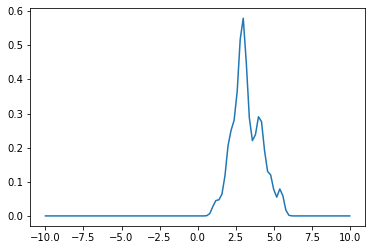

In [115]:
plt.plot(z_grid, cde_test[0])

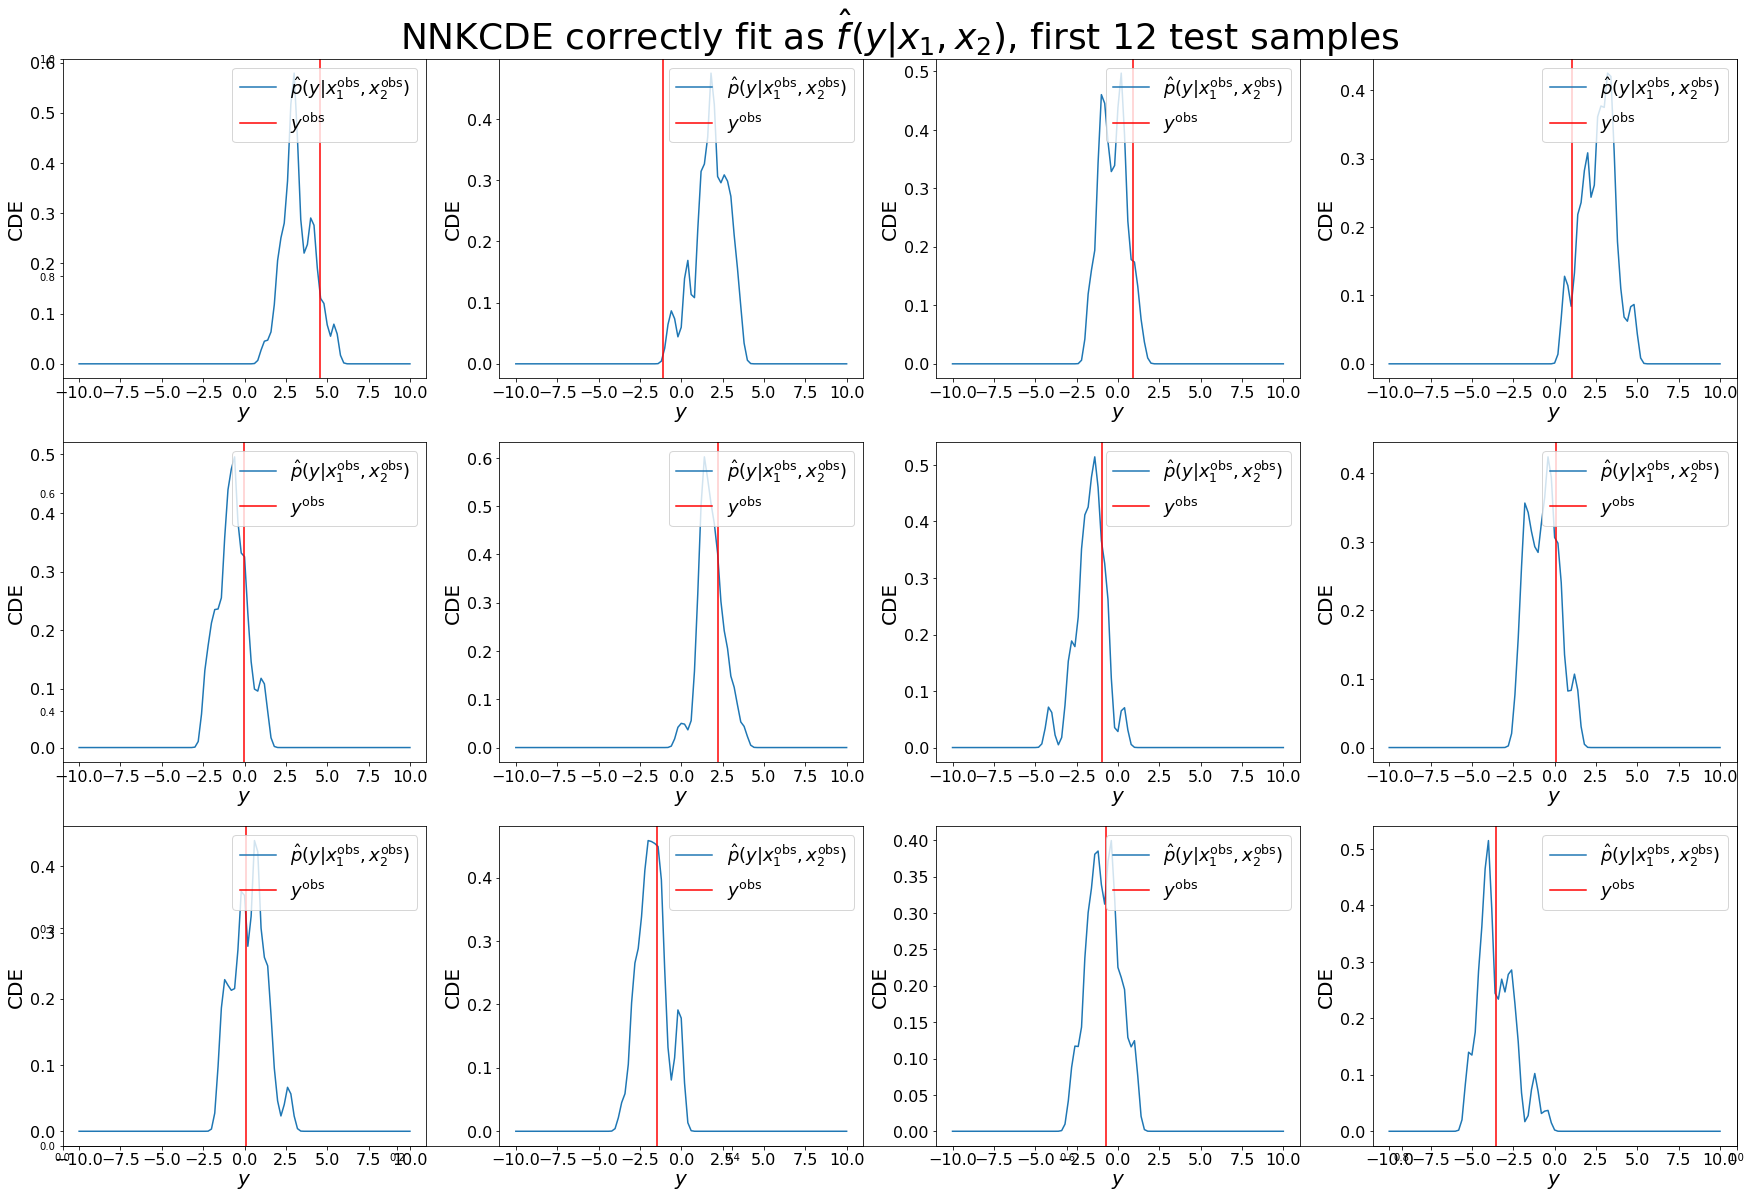

In [116]:
fig = plt.figure(figsize=(30, 20))
plt.title("NNKCDE correctly fit as $\hat f(y|x_1,x_2)$, first 12 test samples", fontsize=36)
for jj, cde_predicted in enumerate(cde_test[:12,:]):
    ax = fig.add_subplot(3, 4, jj + 1)
    plt.plot(z_grid, cde_predicted, label=r'$\hat{p}(y| x_1^{\rm obs}, x_2^{\rm obs})$')
    plt.axvline(Y_test[jj], color='red', label=r'$y^{\rm obs}$')
    plt.xticks(size=16)
    plt.yticks(size=16)
    plt.xlabel(r'$y$', size=20)
    plt.ylabel('CDE', size=20)
    plt.legend(loc='upper right', prop={'size': 18})
plt.show()

In [117]:
print(type(cde_test), cde_test.shape)

den_integral = simps(cde_test[0, :], x=z_grid)
print('Integral of the first density integrates to: %.2f' % den_integral)

<class 'numpy.ndarray'> (40000, 101)
Integral of the first density integrates to: 1.00


# fit incorrect NNKCDEs

In [118]:
cutoff_idx = 60000
X_train = np.array(X_data[:cutoff_idx])
X_test = np.array(X_data[cutoff_idx:])
Y_train = np.array(Y_data[:cutoff_idx])
Y_test = np.array(Y_data[cutoff_idx:])

In [119]:
k = 50
bandwidth = 0.2
model_X = nnkcde.NNKCDE(k=k)
model_X.fit(x_train=X_train, z_train=Y_train)

In [120]:
n_grid = 101
bandwidth = 0.2
z_grid = np.linspace(-10, 10, n_grid)

In [121]:
%%time

cde_test_X = model_X.predict(X_test, z_grid, bandwidth=bandwidth)

Wall time: 10.2 s


In [125]:
print(type(cde_test_X), cde_test_X.shape)

den_integral = simps(cde_test_X[0, :], x=z_grid)
print('Integral of the first density integrates to: %.2f' % den_integral)

<class 'numpy.ndarray'> (40000, 101)
Integral of the first density integrates to: 1.00


# PIT uniformity test: all NNKCDEs pass

In [128]:
pit_values = cdf_coverage(cde_test, z_grid, Y_test)
pit_values_X = cdf_coverage(cde_test_X, z_grid, Y_test)
pit_values_Z = cdf_coverage(cde_test_Z, z_grid, Y_test)

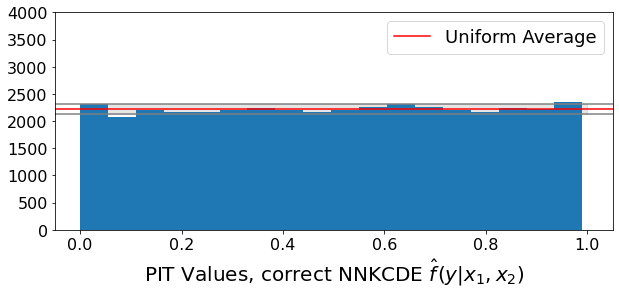

In [194]:
fig_pit = plot_with_uniform_band(values=pit_values, ci_level=0.95, x_label='PIT Values, correct NNKCDE $\hat f(y|x_1,x_2)$', n_bins=18, ylim=[0, 4000])
fig_pit

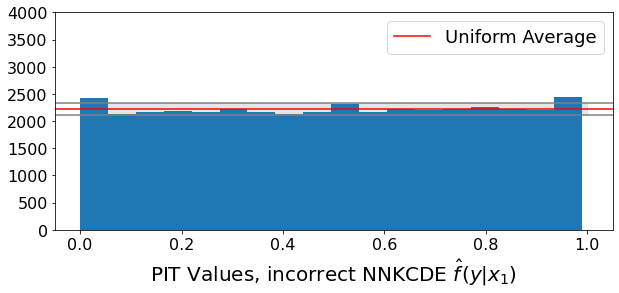

In [195]:
fig_pit = plot_with_uniform_band(values=pit_values_X, ci_level=0.99, x_label='PIT Values, incorrect NNKCDE $\hat f(y|x_1)$', n_bins=18, ylim=[0, 4000])
fig_pit

# saved $\hat r$ from MC samples, to build CIs

In [153]:
with open("data/all_rhat_classifiers_2021-02-01-01-07.pkl", 'rb') as handle:
    all_rhat_classifiers = pickle.load(handle)

In [156]:
def get_confidence_band_range(n_trials=100, name='x1x2', alpha=0.05, points=[[1,2]]):
    sample = [all_rhat_classifiers[i][name][alpha].predict_proba(points)[:, 1][0] for i in range(n_trials)]
    return [min(sample), max(sample)]

# fixed $\alpha$, coverage heatmap

In [156]:
alpha = 0.2

In [178]:
x_range = np.linspace(-2,2,41)
x, z = np.meshgrid(x_range, x_range)
grid = np.hstack([x.ravel().reshape(-1,1), z.ravel().reshape(-1,1)])
x_range_round = [round(x,1) for x in x_range]

In [158]:
ind_pit_values = [1*(x<=alpha) for x in pit_values]
ind_pit_values_X = [1*(x<=alpha) for x in pit_values_X]

In [159]:
rhat_alpha = MLPClassifier(alpha=0, max_iter=25000)
rhat_alpha.fit(X=XZ_test, y=ind_pit_values)

MLPClassifier(activation='relu', alpha=0, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_iter=25000, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [160]:
rhat_alpha_X = MLPClassifier(alpha=0, max_iter=25000)
rhat_alpha_X.fit(X=XZ_test, y=ind_pit_values_X)

MLPClassifier(activation='relu', alpha=0, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_iter=25000, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [179]:
alpha_pred = rhat_alpha.predict_proba(grid)[:, 1]
alpha_pred_X = rhat_alpha_X.predict_proba(grid)[:, 1]

In [159]:
confidence_fixedalpha = {}
confidence_fixedalpha['XZ'] = np.array([get_confidence_band_range(name='XZ', alpha=alpha, points=[grid[i]])
                                          for i in range(len(grid))])
confidence_fixedalpha['X'] = np.array([get_confidence_band_range(name='X', alpha=alpha, points=[grid[i]])
                                        for i in range(len(grid))])

In [ ]:
fixedalpha_within_null = {}
fixedalpha_within_null['XZ'] = np.array([1 * (alpha_pred[i] < confidence_fixedalpha['XZ'][i][0]
          or alpha_pred[i] > confidence_fixedalpha['XZ'][i][1]) for i in range(len(alpha_pred))])
fixedalpha_within_null['X'] = np.array([1 * (alpha_pred_x1[i] < confidence_fixedalpha['X'][i][0]
          or alpha_pred_x1[i] > confidence_fixedalpha['X'][i][1]) for i in range(len(alpha_pred))])

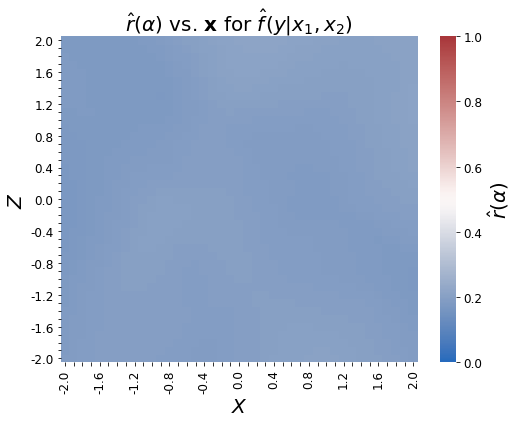

In [181]:
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(alpha_pred.reshape(41,41), xticklabels=x_range_round, yticklabels=x_range_round,
            cbar_kws={'label': "$\hat r($" + r'$\alpha$' + "$)$"}, cmap='vlag', vmin=0, vmax=1)
ax.invert_yaxis()

plt.title("$\hat r($" + r'$\alpha$' + "$)$ vs. $\mathbf{x}$ for $\hat f(y|x_1,x_2)$", fontsize=20)
plt.xlabel('$X$', fontsize=20)
plt.ylabel('$Z$', fontsize=20)

ax.tick_params(axis='both', which='major', labelsize=12)
cbar_axes = ax.figure.axes[-1]
cbar_axes.yaxis.label.set_size(20)
cbar_axes.tick_params(labelsize=12)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

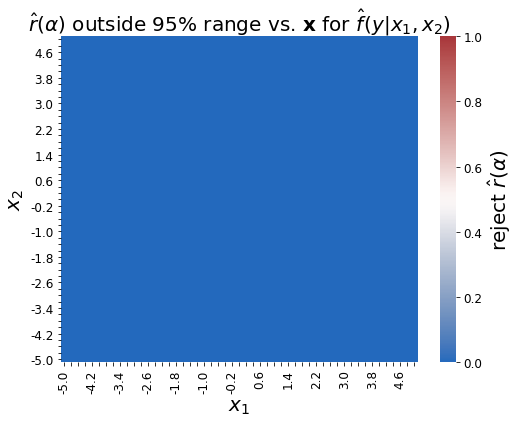

In [167]:
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(fixedalpha_within_null['x1x2'].reshape(41,41), xticklabels=x_range_round, yticklabels=x_range_round,
            cbar_kws={'label': "reject $\hat r($" + r'$\alpha$' + "$)$"}, cmap='vlag', vmin=0, vmax=1)
ax.invert_yaxis()

plt.title("$\hat r($" + r'$\alpha$' + "$)$ outside 95% range vs. $\mathbf{x}$ for $\hat f(y|x_1,x_2)$", fontsize=20)
plt.xlabel('$x_1$', fontsize=20)
plt.ylabel('$x_2$', fontsize=20)

ax.tick_params(axis='both', which='major', labelsize=12)
cbar_axes = ax.figure.axes[-1]
cbar_axes.yaxis.label.set_size(20)
cbar_axes.tick_params(labelsize=12)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

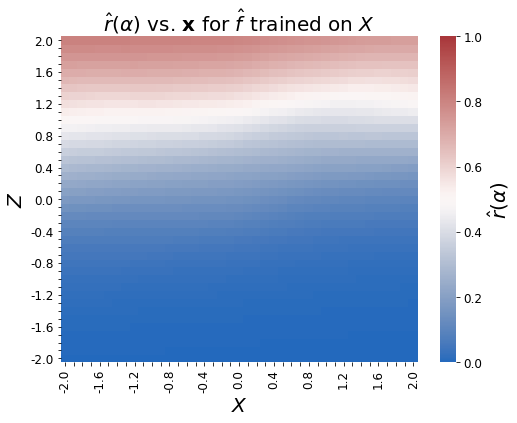

In [182]:
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(alpha_pred_X.reshape(41,41), xticklabels=x_range_round, yticklabels=x_range_round,
            cbar_kws={'label': "$\hat r($" + r'$\alpha$' + "$)$"}, cmap='vlag', vmin=0, vmax=1)
ax.invert_yaxis()

plt.title("$\hat r($" + r'$\alpha$' + "$)$ vs. $\mathbf{x}$ for $\hat f$ trained on $X$", fontsize=20)
plt.xlabel('$X$', fontsize=20)
plt.ylabel('$Z$', fontsize=20)

ax.tick_params(axis='both', which='major', labelsize=12)
cbar_axes = ax.figure.axes[-1]
cbar_axes.yaxis.label.set_size(20)
cbar_axes.tick_params(labelsize=12)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(fixedalpha_within_null['X'].reshape(41,41), xticklabels=x_range_round, yticklabels=x_range_round,
            cbar_kws={'label': "reject $\hat r($" + r'$\alpha$' + "$)$"}, cmap='vlag', vmin=0, vmax=1)
ax.invert_yaxis()

plt.title("$\hat r($" + r'$\alpha$' + "$)$ outside 95% range vs. $\mathbf{x}$ for $\hat f$ trained on $X$", fontsize=20)
plt.xlabel('$x_1$', fontsize=20)
plt.ylabel('$x_2$', fontsize=20)

ax.tick_params(axis='both', which='major', labelsize=12)
cbar_axes = ax.figure.axes[-1]
cbar_axes.yaxis.label.set_size(20)
cbar_axes.tick_params(labelsize=12)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

# fixed $\mathbf{x}_i$, QQ plot of $\hat r_\alpha(\mathbf{x}_i)$ vs. $\alpha$

In [200]:
x = 1
z = -1
points = np.array([[x,z]])

In [201]:
alphas = np.linspace(0.01, 0.99, 99)
pit_values_dict = {'XZ': pit_values, 'X': pit_values_X}

In [177]:
rhat_alphas_xi = {}
for name, pit in pit_values_dict.items():
    print("working on classifier %s" % name)
    rhat_alphas_xi[name] = {}
    for alpha in alphas:
        print(alpha)
        ind_values = [1*(x<=alpha) for x in pit]
        rhat = MLPClassifier(alpha=0, max_iter=25000)
        rhat.fit(X=XZ_test, y=ind_values)
        rhat_alphas_xi[name][alpha] = rhat.predict_proba(points)[:, 1][0]
rhat_alphas_xi = pd.DataFrame(rhat_alphas_xi)

working on classifier XZ
0.01
0.02
0.03
0.04
0.05
0.060000000000000005
0.06999999999999999
0.08
0.09
0.09999999999999999
0.11
0.12
0.13
0.14
0.15000000000000002
0.16
0.17
0.18000000000000002
0.19
0.2
0.21000000000000002
0.22
0.23
0.24000000000000002
0.25
0.26
0.27
0.28
0.29000000000000004
0.3
0.31
0.32
0.33
0.34
0.35000000000000003
0.36000000000000004
0.37
0.38
0.39
0.4
0.41000000000000003
0.42000000000000004
0.43
0.44
0.45
0.46
0.47000000000000003
0.48000000000000004
0.49
0.5
0.51
0.52
0.53
0.54
0.55
0.56
0.5700000000000001
0.5800000000000001
0.59
0.6
0.61
0.62
0.63
0.64
0.65
0.66
0.67
0.68
0.6900000000000001
0.7000000000000001
0.7100000000000001
0.72
0.73
0.74
0.75
0.76
0.77
0.78
0.79
0.8
0.81
0.8200000000000001
0.8300000000000001
0.8400000000000001
0.85
0.86
0.87
0.88
0.89
0.9
0.91
0.92
0.93
0.9400000000000001
0.9500000000000001
0.9600000000000001
0.97
0.98
0.99
working on classifier X
0.01
0.02
0.03
0.04
0.05
0.060000000000000005
0.06999999999999999
0.08
0.09
0.09999999999999999
0.

In [172]:
confidence_qqplot = {}
confidence_qqplot['XZ'] = np.array([get_confidence_band_range(name='XZ', alpha=i, points=points) for i in alphas])
confidence_qqplot['X'] = np.array([get_confidence_band_range(name='X', alpha=i, points=points) for i in alphas])
confidence_qqplot['Z'] = np.array([get_confidence_band_range(name='Z', alpha=i, points=points) for i in alphas])
confidence_qqplot['marg'] = np.array([get_confidence_band_range(name='marg', alpha=i, points=points) for i in alphas])

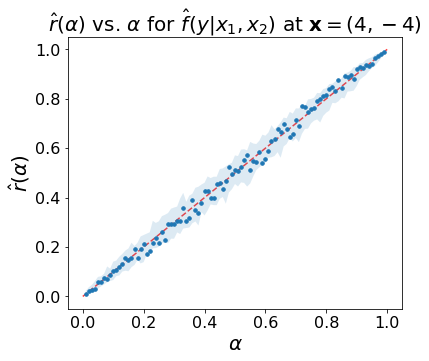

In [173]:
rhat_alphas_xi['XZ'].plot(style='.', figsize=(6,5), markersize=7)

lims = [
    np.min([0,0]),  # min of both axes
    np.max([1,1]),  # max of both axes
]
plt.plot(lims, lims, 'r--', alpha=0.75, zorder=0)

"""
# confidence bands
plt.fill_between(rhat_alphas_xi['XZ'].index,
                 confidence_qqplot['XZ'][:, 0],
                 confidence_qqplot['XZ'][:, 1],
                 alpha=0.15
                )
"""

plt.title("$\hat r($" + r'$\alpha$' + "$)$ vs. " + r'$\alpha$' + " for $\hat f(y|x_1,x_2)$ at $\mathbf{x}=(1,-1)$", fontsize=20)
plt.xlabel(r'$\alpha$', fontsize=20)
plt.ylabel("$\hat r($" + r'$\alpha$' + "$)$", fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=16)

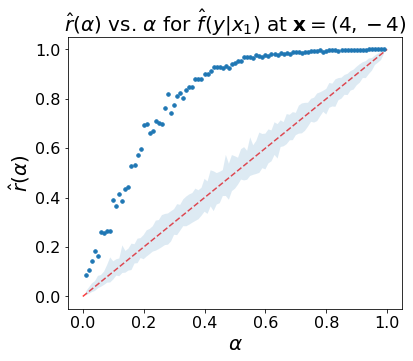

In [174]:
rhat_alphas_xi['X'].plot(style='.', figsize=(6,5), markersize=7)

lims = [
    np.min([0,0]),  # min of both axes
    np.max([1,1]),  # max of both axes
]
plt.plot(lims, lims, 'r--', alpha=0.75, zorder=0)

"""
# confidence bands
plt.fill_between(rhat_alphas_xi['X'].index,
                 confidence_qqplot['X'][:, 0],
                 confidence_qqplot['X'][:, 1],
                 alpha=0.15
                )
"""

plt.title("$\hat r($" + r'$\alpha$' + "$)$ vs. " + r'$\alpha$' + " for $\hat f(y|x_1)$ at $\mathbf{x}=(4,-4)$", fontsize=20)
plt.xlabel(r'$\alpha$', fontsize=20)
plt.ylabel("$\hat r($" + r'$\alpha$' + "$)$", fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=16)

In [197]:
#with open('rhat_alphas_xi_20210205.pkl', 'wb') as handle:
#    pickle.dump(rhat_alphas_xi, handle, protocol=pickle.HIGHEST_PROTOCOL)

# heat map of $T_i = \frac{1}{|G|} \sum_{\alpha \in G} (\hat r_\alpha(\mathbf{x}_i) - \alpha)^2$

In [71]:
Ti_values = {}
all_rhat_alphas = {}
for name, pit in pit_values_dict.items():
    print("working on classifier %s" % name)
    all_rhat_alphas[name] = {}
    for alpha in alphas:
        print(alpha)
        ind_values = [1*(x<=alpha) for x in pit]
        rhat = MLPClassifier(alpha=0, max_iter=25000)
        rhat.fit(X=x_test, y=ind_values)
        
        # fit rhat at each point in prediction grid
        all_rhat_alphas[name][alpha] = rhat.predict_proba(grid)[:, 1]
        
    # rhat_alphas for all alphas at all points
    all_rhat_alphas[name] = pd.DataFrame(all_rhat_alphas[name])
    
    # compute Ti summary statistic
    Ti_values[name] = ((all_rhat_alphas[name] - alphas)**2).sum(axis=1) / len(alphas)

working on classifier x1x2
0.01
0.02
0.03
0.04
0.05
0.060000000000000005
0.06999999999999999
0.08
0.09
0.09999999999999999
0.11
0.12
0.13
0.14
0.15000000000000002
0.16
0.17
0.18000000000000002
0.19
0.2
0.21000000000000002
0.22
0.23
0.24000000000000002
0.25
0.26
0.27
0.28
0.29000000000000004
0.3
0.31
0.32
0.33
0.34
0.35000000000000003
0.36000000000000004
0.37
0.38
0.39
0.4
0.41000000000000003
0.42000000000000004
0.43
0.44
0.45
0.46
0.47000000000000003
0.48000000000000004
0.49
0.5
0.51
0.52
0.53
0.54
0.55
0.56
0.5700000000000001
0.5800000000000001
0.59
0.6
0.61
0.62
0.63
0.64
0.65
0.66
0.67
0.68
0.6900000000000001
0.7000000000000001
0.7100000000000001
0.72
0.73
0.74
0.75
0.76
0.77
0.78
0.79
0.8
0.81
0.8200000000000001
0.8300000000000001
0.8400000000000001
0.85
0.86
0.87
0.88
0.89
0.9
0.91
0.92
0.93
0.9400000000000001
0.9500000000000001
0.9600000000000001
0.97
0.98
0.99
working on classifier x1
0.01
0.02
0.03
0.04
0.05
0.060000000000000005
0.06999999999999999
0.08
0.09
0.09999999999999999

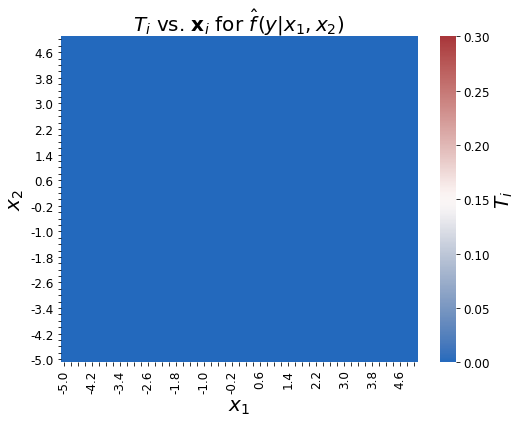

In [72]:
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(Ti_values['x1x2'].values.reshape(51,51), xticklabels=x_range_round, yticklabels=x_range_round,
            cbar_kws={'label': "$T_i$"}, cmap='vlag', vmin=0, vmax=0.3)
ax.invert_yaxis()

plt.title("$T_i$ vs. $\mathbf{x}_i$ for $\hat f(y|x_1,x_2)$", fontsize=20)
plt.xlabel('$x_1$', fontsize=20)
plt.ylabel('$x_2$', fontsize=20)

ax.tick_params(axis='both', which='major', labelsize=12)
cbar_axes = ax.figure.axes[-1]
cbar_axes.yaxis.label.set_size(20)
cbar_axes.tick_params(labelsize=12)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

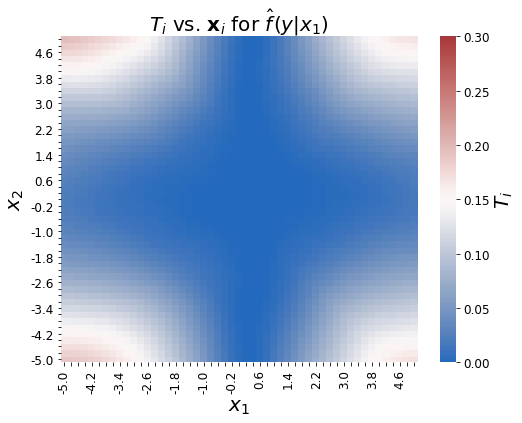

In [73]:
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(Ti_values['x1'].values.reshape(51,51), xticklabels=x_range_round, yticklabels=x_range_round,
            cbar_kws={'label': "$T_i$"}, cmap='vlag', vmin=0, vmax=0.3)
ax.invert_yaxis()

plt.title("$T_i$ vs. $\mathbf{x}_i$ for $\hat f(y|x_1)$", fontsize=20)
plt.xlabel('$x_1$', fontsize=20)
plt.ylabel('$x_2$', fontsize=20)

ax.tick_params(axis='both', which='major', labelsize=12)
cbar_axes = ax.figure.axes[-1]
cbar_axes.yaxis.label.set_size(20)
cbar_axes.tick_params(labelsize=12)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

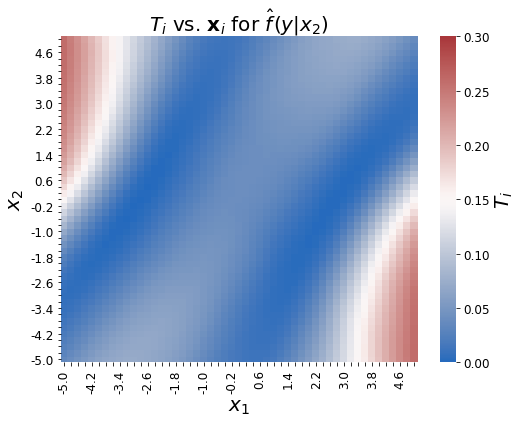

In [74]:
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(Ti_values['x2'].values.reshape(51,51), xticklabels=x_range_round, yticklabels=x_range_round,
            cbar_kws={'label': "$T_i$"}, cmap='vlag', vmin=0, vmax=0.3)
ax.invert_yaxis()

plt.title("$T_i$ vs. $\mathbf{x}_i$ for $\hat f(y|x_2)$", fontsize=20)
plt.xlabel('$x_1$', fontsize=20)
plt.ylabel('$x_2$', fontsize=20)

ax.tick_params(axis='both', which='major', labelsize=12)
cbar_axes = ax.figure.axes[-1]
cbar_axes.yaxis.label.set_size(20)
cbar_axes.tick_params(labelsize=12)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

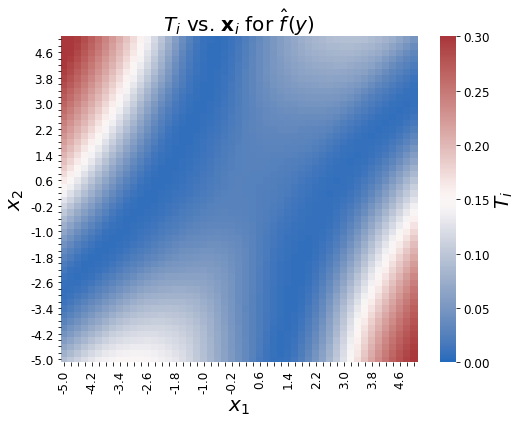

In [75]:
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(Ti_values['marg'].values.reshape(51,51), xticklabels=x_range_round, yticklabels=x_range_round,
            cbar_kws={'label': "$T_i$"}, cmap='vlag', vmin=0, vmax=0.3)
ax.invert_yaxis()

plt.title("$T_i$ vs. $\mathbf{x}_i$ for $\hat f(y)$", fontsize=20)
plt.xlabel('$x_1$', fontsize=20)
plt.ylabel('$x_2$', fontsize=20)

ax.tick_params(axis='both', which='major', labelsize=12)
cbar_axes = ax.figure.axes[-1]
cbar_axes.yaxis.label.set_size(20)
cbar_axes.tick_params(labelsize=12)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

In [78]:
#with open('Ti_values_20210127.pkl', 'wb') as handle:
#    pickle.dump(Ti_values, handle, protocol=pickle.HIGHEST_PROTOCOL)

# global p-value based on $T_i$

In [462]:
global_pvalues = sum([1* (pd.DataFrame(true_Ti_values).mean() < pd.DataFrame(all_unif_Ti_values[i]).mean())
                   for i in range(len(all_unif_Ti_values))]) / len(all_unif_Ti_values)
global_pvalues

x1x2    0.09
x1      0.00
x2      0.00
marg    0.00
dtype: float64

# local p-values based on $T_i$: local CvM test

In [63]:
#with open('pit_values_dict.pkl', 'wb') as handle:
#    pickle.dump(pit_values_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [64]:
#np.save('x_test.npy', x_test)

In [106]:
all_rhat_classifiers[0]['x1x2']

{0.01: MLPClassifier(activation='relu', alpha=0, batch_size='auto', beta_1=0.9,
               beta_2=0.999, early_stopping=False, epsilon=1e-08,
               hidden_layer_sizes=(100,), learning_rate='constant',
               learning_rate_init=0.001, max_iter=25000, momentum=0.9,
               n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
               random_state=None, shuffle=True, solver='adam', tol=0.0001,
               validation_fraction=0.1, verbose=False, warm_start=False),
 0.02: MLPClassifier(activation='relu', alpha=0, batch_size='auto', beta_1=0.9,
               beta_2=0.999, early_stopping=False, epsilon=1e-08,
               hidden_layer_sizes=(100,), learning_rate='constant',
               learning_rate_init=0.001, max_iter=25000, momentum=0.9,
               n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
               random_state=None, shuffle=True, solver='adam', tol=0.0001,
               validation_fraction=0.1, verbose=False, war

In [146]:
all_rhat_classifiers[0]['x1x2'][0.05].predict_proba([[1,2]])

array([[0.95498506, 0.04501494]])

In [107]:
with open("data/Ti_values_20210127.pkl", 'rb') as handle:
    true_Ti_values = pickle.load(handle)
with open("data/all_unif_Ti_values_2021-02-01-01-07.pkl", 'rb') as handle:
    all_unif_Ti_values = pickle.load(handle)

In [108]:
all_pvalues = sum([1* (pd.DataFrame(true_Ti_values) < pd.DataFrame(all_unif_Ti_values[i]))
                   for i in range(len(all_unif_Ti_values))]) / len(all_unif_Ti_values)
all_pvalues

,x1x2,x1,x2,marg
0,0.725,0.0,0.0,0.0
1,0.745,0.0,0.0,0.0
2,0.720,0.0,0.0,0.0
3,0.720,0.0,0.0,0.0
4,0.720,0.0,0.0,0.0
...,...,...,...,...
2596,0.875,0.0,0.0,0.0
2597,0.870,0.0,0.0,0.0
2598,0.860,0.0,0.0,0.0
2599,0.770,0.0,0.0,0.0


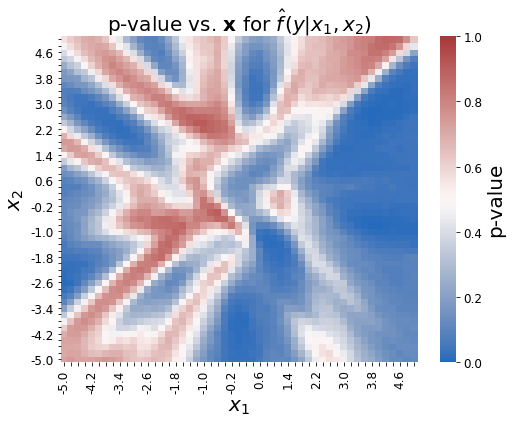

In [109]:
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(all_pvalues['x1x2'].values.reshape(51,51), xticklabels=x_range_round, yticklabels=x_range_round,
            cbar_kws={'label': "p-value"}, cmap='vlag', vmin=0, vmax=1)
ax.invert_yaxis()

plt.title("p-value vs. $\mathbf{x}$ for $\hat f(y|x_1,x_2)$", fontsize=20)
plt.xlabel('$x_1$', fontsize=20)
plt.ylabel('$x_2$', fontsize=20)

ax.tick_params(axis='both', which='major', labelsize=12)
cbar_axes = ax.figure.axes[-1]
cbar_axes.yaxis.label.set_size(20)
cbar_axes.tick_params(labelsize=12)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

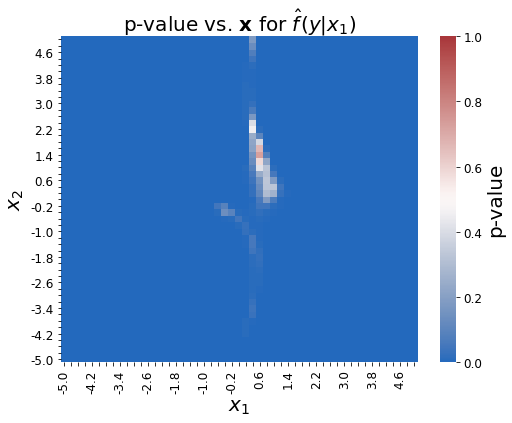

In [110]:
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(all_pvalues['x1'].values.reshape(51,51), xticklabels=x_range_round, yticklabels=x_range_round,
            cbar_kws={'label': "p-value"}, cmap='vlag', vmin=0, vmax=1)
ax.invert_yaxis()

plt.title("p-value vs. $\mathbf{x}$ for $\hat f(y|x_1)$", fontsize=20)
plt.xlabel('$x_1$', fontsize=20)
plt.ylabel('$x_2$', fontsize=20)

ax.tick_params(axis='both', which='major', labelsize=12)
cbar_axes = ax.figure.axes[-1]
cbar_axes.yaxis.label.set_size(20)
cbar_axes.tick_params(labelsize=12)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

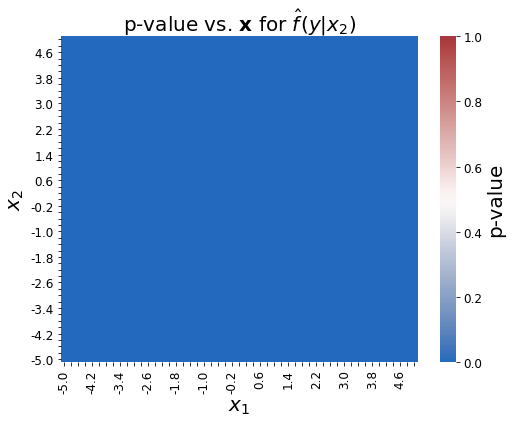

In [111]:
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(all_pvalues['x2'].values.reshape(51,51), xticklabels=x_range_round, yticklabels=x_range_round,
            cbar_kws={'label': "p-value"}, cmap='vlag', vmin=0, vmax=1)
ax.invert_yaxis()

plt.title("p-value vs. $\mathbf{x}$ for $\hat f(y|x_2)$", fontsize=20)
plt.xlabel('$x_1$', fontsize=20)
plt.ylabel('$x_2$', fontsize=20)

ax.tick_params(axis='both', which='major', labelsize=12)
cbar_axes = ax.figure.axes[-1]
cbar_axes.yaxis.label.set_size(20)
cbar_axes.tick_params(labelsize=12)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

# \hat(f)(y|g(x1,x2)) where g(x1,x2) could be x1, or x2, or x1+x2

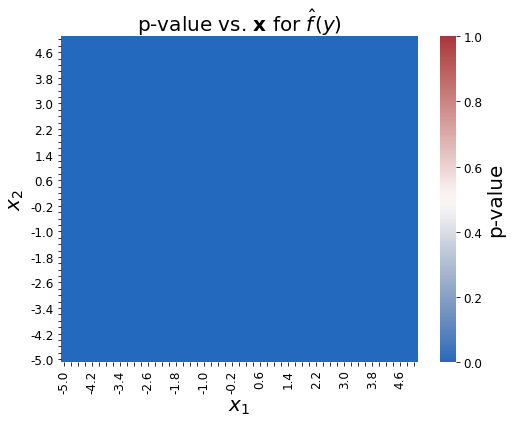

In [112]:
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(all_pvalues['marg'].values.reshape(51,51), xticklabels=x_range_round, yticklabels=x_range_round,
            cbar_kws={'label': "p-value"}, cmap='vlag', vmin=0, vmax=1)
ax.invert_yaxis()

plt.title("p-value vs. $\mathbf{x}$ for $\hat f(y)$", fontsize=20)
plt.xlabel('$x_1$', fontsize=20)
plt.ylabel('$x_2$', fontsize=20)

ax.tick_params(axis='both', which='major', labelsize=12)
cbar_axes = ax.figure.axes[-1]
cbar_axes.yaxis.label.set_size(20)
cbar_axes.tick_params(labelsize=12)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

# Benjamini-Hochberg FDR correction

In [136]:
m = 51*51
alpha = 0.05

In [137]:
bh_values = alpha * (np.arange(m) + 1) / m

In [138]:
f_type = 'x1x2'
pval_vs_bh = 1*(all_pvalues[f_type].sort_values() <= bh_values)
use_idx = pval_vs_bh.index
pval_vs_bh_sorted = pd.Series(pval_vs_bh.values, index=np.arange(m)+1)
all_rejected_idxs = pval_vs_bh_sorted[pval_vs_bh_sorted == 1].index
last_rejected_idx = all_rejected_idxs[-1] if len(all_rejected_idxs) > 0 else 0
bh_rejections = pd.Series(np.hstack([np.ones(last_rejected_idx), np.zeros(m-last_rejected_idx)]),
                          index=use_idx)

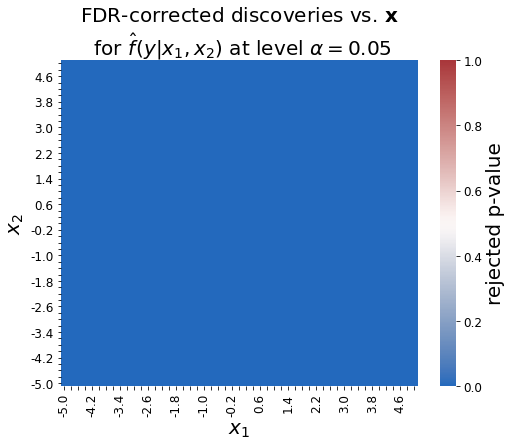

In [139]:
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(bh_rejections.sort_index().values.reshape(51,51), xticklabels=x_range_round, yticklabels=x_range_round,
            cbar_kws={'label': "rejected p-value"}, cmap='vlag', vmin=0, vmax=1)
ax.invert_yaxis()

plt.title("FDR-corrected discoveries vs. $\mathbf{x}$\n for $\hat f(y|x_1,x_2)$ at level " + r'$\alpha=0.05$', fontsize=20)
plt.xlabel('$x_1$', fontsize=20)
plt.ylabel('$x_2$', fontsize=20)

ax.tick_params(axis='both', which='major', labelsize=12)
cbar_axes = ax.figure.axes[-1]
cbar_axes.yaxis.label.set_size(20)
cbar_axes.tick_params(labelsize=12)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

In [140]:
f_type = 'x1'
pval_vs_bh_x1 = 1*(all_pvalues[f_type].sort_values() <= bh_values)
use_idx = pval_vs_bh_x1.index
pval_vs_bh_x1_sorted = pd.Series(pval_vs_bh_x1.values, index=np.arange(m)+1)
last_rejected_idx = pval_vs_bh_sorted[pval_vs_bh_x1_sorted == 1].index[-1]
bh_rejections_x1 = pd.Series(np.hstack([np.ones(last_rejected_idx), np.zeros(m-last_rejected_idx)]),
                             index=use_idx)

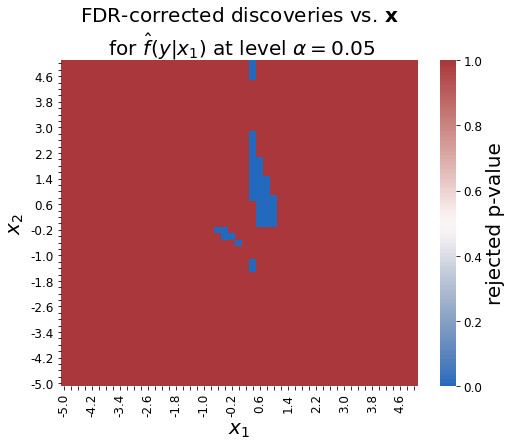

In [141]:
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(bh_rejections_x1.sort_index().values.reshape(51,51), xticklabels=x_range_round, yticklabels=x_range_round,
            cbar_kws={'label': "rejected p-value"}, cmap='vlag', vmin=0, vmax=1)
ax.invert_yaxis()

plt.title("FDR-corrected discoveries vs. $\mathbf{x}$\n for $\hat f(y|x_1)$ at level " + r'$\alpha=0.05$', fontsize=20)
plt.xlabel('$x_1$', fontsize=20)
plt.ylabel('$x_2$', fontsize=20)

ax.tick_params(axis='both', which='major', labelsize=12)
cbar_axes = ax.figure.axes[-1]
cbar_axes.yaxis.label.set_size(20)
cbar_axes.tick_params(labelsize=12)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

In [142]:
f_type = 'x2'
pval_vs_bh_x2 = 1*(all_pvalues[f_type].sort_values() <= bh_values)
use_idx = pval_vs_bh_x2.index
pval_vs_bh_x2_sorted = pd.Series(pval_vs_bh_x2.values, index=np.arange(m)+1)
last_rejected_idx = pval_vs_bh_sorted[pval_vs_bh_x2_sorted == 1].index[-1]
bh_rejections_x2 = pd.Series(np.hstack([np.ones(last_rejected_idx), np.zeros(m-last_rejected_idx)]),
                             index=use_idx)

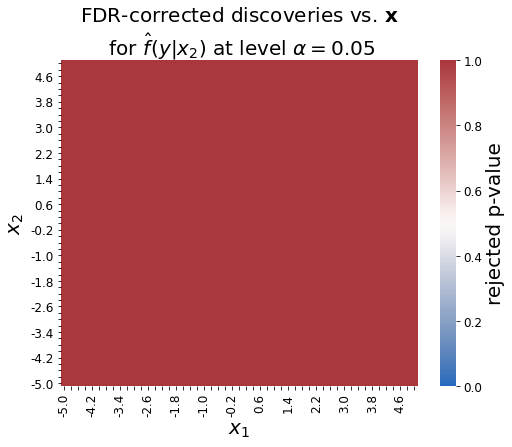

In [143]:
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(bh_rejections_x2.sort_index().values.reshape(51,51), xticklabels=x_range_round, yticklabels=x_range_round,
            cbar_kws={'label': "rejected p-value"}, cmap='vlag', vmin=0, vmax=1)
ax.invert_yaxis()

plt.title("FDR-corrected discoveries vs. $\mathbf{x}$\n for $\hat f(y|x_2)$ at level " + r'$\alpha=0.05$', fontsize=20)
plt.xlabel('$x_1$', fontsize=20)
plt.ylabel('$x_2$', fontsize=20)

ax.tick_params(axis='both', which='major', labelsize=12)
cbar_axes = ax.figure.axes[-1]
cbar_axes.yaxis.label.set_size(20)
cbar_axes.tick_params(labelsize=12)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

In [144]:
f_type = 'marg'
pval_vs_bh_marg = 1*(all_pvalues[f_type].sort_values() <= bh_values)
use_idx = pval_vs_bh_marg.index
pval_vs_bh_marg_sorted = pd.Series(pval_vs_bh_marg.values, index=np.arange(m)+1)
last_rejected_idx = pval_vs_bh_marg_sorted[pval_vs_bh_marg_sorted == 1].index[-1]
bh_rejections_marg = pd.Series(np.hstack([np.ones(last_rejected_idx), np.zeros(m-last_rejected_idx)]),
                               index=use_idx)

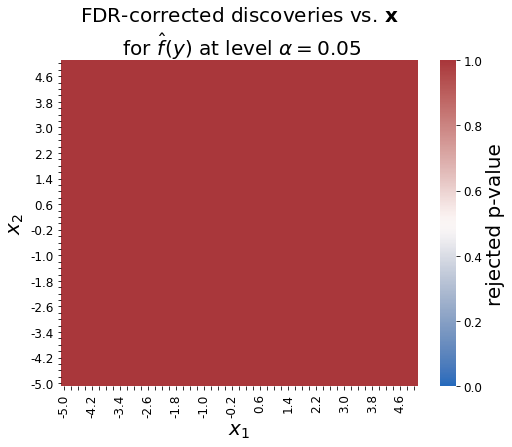

In [145]:
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(bh_rejections_marg.sort_index().values.reshape(51,51), xticklabels=x_range_round, yticklabels=x_range_round,
            cbar_kws={'label': "rejected p-value"}, cmap='vlag', vmin=0, vmax=1)
ax.invert_yaxis()

plt.title("FDR-corrected discoveries vs. $\mathbf{x}$\n for $\hat f(y)$ at level " + r'$\alpha=0.05$', fontsize=20)
plt.xlabel('$x_1$', fontsize=20)
plt.ylabel('$x_2$', fontsize=20)

ax.tick_params(axis='both', which='major', labelsize=12)
cbar_axes = ax.figure.axes[-1]
cbar_axes.yaxis.label.set_size(20)
cbar_axes.tick_params(labelsize=12)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)
for n, label in enumerate(ax.yaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)